In [ ]:
%pip install git+https://github.com/mauricef/halite-iv-jax.git@9e04bec18a5b45deb3e1828b277115365318b914 \
    seaborn \
    dm-haiku \
    optax \
    kaggle-environments

In [1]:
%load_ext autoreload
%autoreload 2

# Random Agent Actor
Predict actions of random agent.

In [1]:
import copy
from collections import namedtuple
import haiku as hk
from jax import random, jit, partial, vmap, value_and_grad, grad, lax, ops, nn
import jax.numpy as np
import jax.nn as nn
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns

from halite_jax import State, Cell, Episode, Trajectory
from halite_jax import tree_index, tree_batch
from halite_jax import net_present_value
from halite_jax import generate_episode
from halite_jax import Action
from halite_jax import make_config
from halite_jax import render_episode, render_state
from halite_jax import vmap_random
rng = random.PRNGKey(42)

Loading environment football failed: No module named 'gfootball'


In [2]:
episode_steps = 50
board_size = 5
board_shape = (board_size, board_size)
cell_count = board_size ** 2
configuration = make_config(size=board_size, episodeSteps=episode_steps, regenRate=0., maxCellHalite=1., collectRate=1.)
owner = np.repeat(np.array([0, -1], int), np.array([1, 0]), total_repeat_length=cell_count).reshape(board_shape)
ship = np.repeat(np.array([1, 0], bool), np.array([1, 0]), total_repeat_length=cell_count).reshape(board_shape)
initial_state = State(
    halite=np.zeros((1,)),
    step=np.array(0.),
    cells=Cell(
        owner=owner,
        halite=np.ones(board_shape),
        shipyard=np.zeros(board_shape, bool),
        ship=ship,
        cargo=np.zeros(board_shape)
    )
)

In [3]:
def random_move_agent(state, rng, player):
    return Action(
        ship=random.randint(rng, minval=0, maxval=5, shape=state.cells.ship.shape),
        shipyard=np.zeros_like(state.cells.shipyard))

agents = [random_move_agent]
generate_episode_for_scenario = jit(partial(generate_episode, configuration, agents, initial_state))

In [4]:
discount_rate = 1.

@jit
def generate_trajectory(rng):
    rng, r = random.split(rng)
    states, actions = generate_episode_for_scenario(r)
    cargo = np.sum(states.cells.cargo, (1, 2))
    rewards = np.diff(cargo)
    values = net_present_value(discount_rate, rewards)
    states = tree_index(states, ops.index[:-1])
    return Trajectory(Episode(states, actions), rewards, values)

In [5]:
batch_generate_trajectory = vmap_random(generate_trajectory)

In [6]:
training_episode_count = 4096
training_episode_per_batch = 64
training_data_num_batches = training_episode_count // training_episode_per_batch

rng, r = random.split(rng)
training_data = batch_generate_trajectory(r, batch_size=training_episode_count)
training_data = tree_map(np.concatenate, training_data) # flatten the episodes
training_data_batches = tree_batch(training_data, training_data_num_batches)

In [7]:
ship_action = pd.Categorical(
    np.array(np.sum(training_data.action.ship, (1, 2)), int),
    categories=np.arange(6))
shipyard_action = pd.Categorical(
    np.array(np.sum(training_data.action.shipyard, (1, 2)), int),
    categories=np.arange(2))
df = pd.DataFrame(data=dict(
    ship_action=ship_action,
    shipyard_action=shipyard_action
))

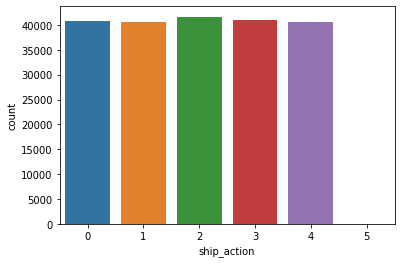

In [8]:
_ = sns.countplot(x='ship_action', data=df)

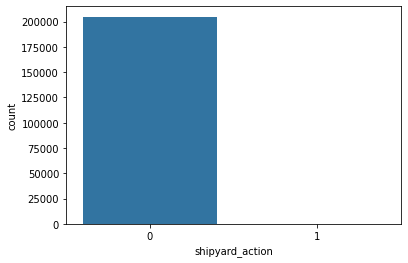

In [9]:
_ = sns.countplot(x='shipyard_action', data=df)

In [10]:
initial_state.cells.ship

DeviceArray([[ True, False, False, False, False],
             [False, False, False, False, False],
             [False, False, False, False, False],
             [False, False, False, False, False],
             [False, False, False, False, False]], dtype=bool)

In [17]:
@hk.without_apply_rng
@hk.transform
def model(state):
    has_ship = np.array(state.cells.ship & (state.cells.owner == 0), float).ravel()
    has_ship = np.expand_dims(has_ship, axis=1)
    ship_linear = hk.Linear(output_size=6, name='ship')
    ship_action = vmap(ship_linear)(has_ship)
    ship_action = np.reshape(ship_action, board_shape + (6,))

    has_shipyard = np.array(state.cells.shipyard & (state.cells.owner == 0), float).ravel()
    has_shipyard = np.expand_dims(has_shipyard, axis=1)
    shipyard_linear = hk.Linear(output_size=2, name='shipyard')
    shipyard_action = vmap(shipyard_linear)(has_ship)
    shipyard_action = np.reshape(shipyard_action, board_shape + (2,))
    return Action(ship=ship_action, shipyard=shipyard_action)

In [18]:
def step_loss(model, model_state, trajectory_step):
    ship_action, shipyard_action = trajectory_step.episode.action
    ship_action_one_hot = nn.one_hot(ship_action, 6)
    shipyard_action_one_hot = nn.one_hot(shipyard_action, 2)
    ship_action_logits, shipyard_action_logits = model.apply(model_state, trajectory_step.state)
    ship_loss = optax.softmax_cross_entropy(ship_action_logits, ship_action_one_hot)
    shipyard_loss = optax.softmax_cross_entropy(shipyard_action_logits, shipyard_action_one_hot)
    loss = ship_loss + shipyard_loss
    loss = np.mean(loss)
    return loss

def trajectory_loss(model, model_state, batch):
    loss = vmap(partial(step_loss, model, model_state))(batch)
    return np.mean(loss)

In [19]:
num_batches = training_data_num_batches
num_epochs = 10
optimizer = optax.adam(learning_rate=1e-2)

def train(rng, model, loss_fn):    
    def train_batch(carry, i):
        model_state, opt_state = carry
        batch = tree_index(training_data_batches, i)
        loss_value, loss_grads = value_and_grad(partial(loss_fn, model, batch=batch))(model_state)
        model_updates, opt_state = optimizer.update(loss_grads, opt_state)
        model_state = optax.apply_updates(model_state, model_updates)
        return (model_state, opt_state), loss_value

    def train_epoch(carry, i):    
        rng, model_state, opt_state = carry
        batch_order = np.arange(num_batches)
        rng, r = random.split(rng)
        batch_order = random.permutation(r, batch_order)
        (model_state, opt_state), loss_value = lax.scan(train_batch, init=(model_state, opt_state), xs=batch_order)
        return (rng, model_state, opt_state), loss_value

    def train_model(rng, model_state, opt_state):
        return lax.scan(train_epoch, init=(rng, model_state, opt_state), xs=np.arange(num_epochs))
    
    rng, r = random.split(rng)
    model_state = model.init(r, initial_state)
    opt_state = optimizer.init(model_state)
    (_, model_state, opt_state), loss_values = train_model(rng, model_state, opt_state)
    loss_values = np.concatenate(loss_values)
    return model_state, opt_state, loss_values

In [20]:
def predict_values(model, model_state):
    return vmap(partial(model.apply, model_state))(training_data.state)

In [21]:
@jit
def run(rng):
    rng, r = random.split(rng)
    model_state, opt_state, loss_values = train(r, model, trajectory_loss)
    predicted_values = vmap(partial(model.apply, model_state))(training_data.state)
    return loss_values, predicted_values, model_state

In [22]:
rng, r = random.split(rng)
loss_values, predicted_values, model_state = run(r)

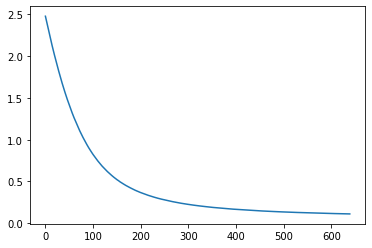

In [23]:
plt.plot(loss_values)
plt.show()

In [89]:
model_state

FlatMapping({
  'ship': FlatMapping({
            'b': DeviceArray([ 2.4714348, -2.4791684, -2.4563723, -2.4800298, -2.4634068,
                              -2.478133 ], dtype=float32),
            'w': DeviceArray([[-2.9345407,  1.9074314,  1.9099535,  1.9097953,  1.861668 ,
                               -3.243357 ]], dtype=float32),
          }),
  'shipyard': FlatMapping({
                'b': DeviceArray([ 2.1119792, -2.1119792], dtype=float32),
                'w': DeviceArray([[ 1.779213 , -0.9446107]], dtype=float32),
              }),
})

## Model Evaluation
The model correctly predicts zero for ship action when there is no ship and evenly between mine/move when there is a ship. Always predicts zero for shipyard.

In [92]:
ship_action = np.ravel(training_data.action.ship)
shipyard_action = np.ravel(training_data.action.shipyard)

In [93]:
has_ship = np.array(training_data.state.cells.ship & (training_data.state.cells.owner == 0), bool).ravel()
predicted_ship_action = np.reshape(predicted_values.ship, (-1, 6))
predicted_ship_action_with_ship = predicted_ship_action[has_ship]
predicted_ship_action_with_ship = nn.softmax(np.mean(predicted_ship_action_with_ship, axis=0))
predicted_ship_action_without_ship = predicted_ship_action[~has_ship]
predicted_ship_action_without_ship = nn.softmax(np.mean(predicted_ship_action_without_ship, axis=0))

<BarContainer object of 6 artists>

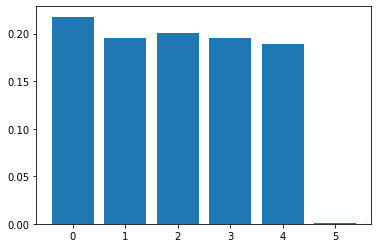

In [94]:
plt.bar(x=np.arange(6), height=predicted_ship_action_with_ship)

<BarContainer object of 6 artists>

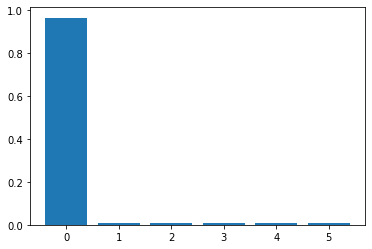

In [95]:
plt.bar(x=np.arange(6), height=predicted_ship_action_without_ship)

In [96]:
has_shipyard = np.array(training_data.state.cells.shipyard & (training_data.state.cells.owner == 0), bool).ravel()
predicted_shipyard_action = np.reshape(predicted_values.shipyard, (-1, 2))
predicted_shipyard_action_with_shipyard = predicted_shipyard_action[has_shipyard]
predicted_shipyard_action_with_shipyard = nn.softmax(np.mean(predicted_shipyard_action_with_shipyard, axis=0))
predicted_shipyard_action_without_shipyard = predicted_shipyard_action[~has_shipyard]
predicted_shipyard_action_without_shipyard = nn.softmax(np.mean(predicted_shipyard_action_without_shipyard, axis=0))

<BarContainer object of 2 artists>

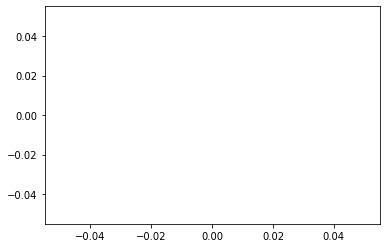

In [97]:
plt.bar(x=np.arange(2), height=predicted_shipyard_action_with_shipyard)

<BarContainer object of 2 artists>

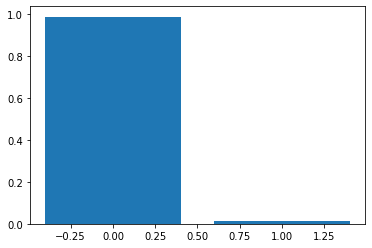

In [98]:
plt.bar(x=np.arange(2), height=predicted_shipyard_action_without_shipyard)